In [1]:
import sys
sys.path.append("D:/API/cocoapi/PythonAPI")

In [2]:
%matplotlib inline
from pycocotools.cocoz import COCOZ, timer
from pycocotools.coco import COCO
from pycocotools import mask
import numpy as np
from matplotlib import pyplot as plt

In [3]:
class COCOFile(COCO, dict):
    def __init__(self, annFile, *args, **kwds):
        super().__init__(*args, **kwds)
        self.__dict__ = self
        self.dataset = COCOFile.json2dict(annFile)
        self.createIndex()
        
    @staticmethod  
    def json2dict(name):
        with open(name) as fp:
            dataset = json.load(fp)
        return dataset
        
    @timer
    def createIndex(self):
        # create index
        print('creating index...')
        cats, anns, imgs = {}, {}, {}
        imgToAnns, catToImgs = {}, {}
        if 'annotations' in self.dataset:
            for ann in self.dataset['annotations']:
                imgToAnns[ann['image_id']] = imgToAnns.get(
                    ann['image_id'], []) + [ann]
                anns[ann['id']] = ann
        if 'images' in self.dataset:
            for img in self.dataset['images']:
                imgs[img['id']] = img
        if 'categories' in self.dataset:
            for cat in self.dataset['categories']:
                cats[cat['id']] = cat
        if 'annotations' in self.dataset and 'categories' in self.dataset:
            for ann in self.dataset['annotations']:
                catToImgs[ann['category_id']] = catToImgs.get(
                    ann['category_id'], []) + [ann['image_id']]

        print('index created!')

        # create class members
        self.anns = anns
        self.imgToAnns = imgToAnns
        self.catToImgs = catToImgs
        self.imgs = imgs
        self.cats = cats

In [4]:
# initialize COCO api for person keypoints annotations
annFile = 'D:/study/RLE/view_rle.json'
coco_kps = COCOFile(annFile)

Loading json in memory ...
creating index...
index created!
used time: 0.00099802 s


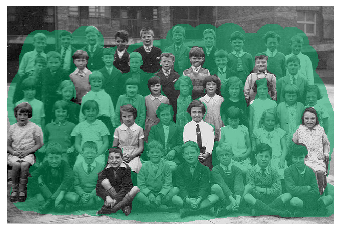

In [5]:
# load and display keypoints annotations
I = plt.imread('D:/study/RLE/69721072-fdb76f80-114e-11ea-9d90-c877f5c8e9f2.jpg')
plt.imshow(I)
plt.axis('off')
ax = plt.gca()
catIds = coco_kps.getCatIds(catNms=['person']);
imgIds = coco_kps.getImgIds(catIds=catIds );
annIds = coco_kps.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=True)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

In [6]:
def get_binary_mask(ann):
    num_keypoints = ann['num_keypoints']
    keypoints = ann['keypoints']
    bbox = ann['bbox']

    counts = ann['segmentation']['counts']
    size = ann['segmentation']['size']

    binary_mask = []
    for count in counts:
        binary_mask.extend([num_keypoints]*count)
        num_keypoints = 1- num_keypoints
    binary_mask = np.array(binary_mask)
    binary_mask = binary_mask.reshape(size, order='F')
    return binary_mask

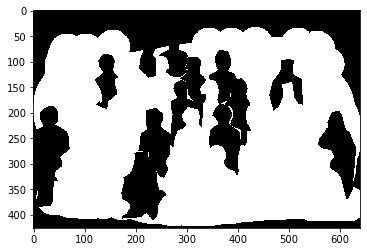

In [7]:
from cv2 import cv2

labels_info = []

# For each annotation
for annotation in anns:

    # Initialize variables
    obj = {}
    segmentation = []
    segmentation_polygons = []

    # Decode the binary mask
    mask_list = get_binary_mask(annotation)
    mask_list = np.ascontiguousarray(mask_list, dtype=np.uint8)
    plt.imshow(mask_list*255, cmap='gray')
    plt.show()
    contours, hierarchy = cv2.findContours((mask_list).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    segmentation = []

    for contour in contours:
        contour = contour.flatten().tolist()
        # segmentation.append(contour)
        if len(contour) > 4:
            segmentation.append(contour)
    if len(segmentation) == 0:
        continue
    # get area, bbox, category_id and so on
    annotation
    labels_info.append(
        {
            "segmentation": segmentation,  # poly
            "area": annotation['area'],  # segmentation area
            "iscrowd": 0,
            "image_id": annotation["image_id"],
            "bbox": annotation["bbox"],
            "category_id": annotation['category_id'],
            "id": annotation["id"]
        },
    )